# Welcome to $^{26}$Al imaging with cosipy classic
In this notebook, we'll use a Richardson-Lucy deconvolution algorithm to image $^{26}$Al emission from the Milky Way Galaxy. As MeV gamma-ray instruments, COSI-balloon and the COSI satellite are uniquely equipped to study the 1.809 MeV signature emission from this radioisotope, which traces stellar nucleosynthesis over millions of years. 

In the 1980s, NASA's High Energy Astrophysical Observatory (HEAO-3) satellite mission detected 1.809 MeV emission emanating from the direction of the Galactic Center [Mahoney et al. 1984](https://adsabs.harvard.edu/pdf/1984ApJ...286..578M). This marked the discovery of Galactic $^{26}$Al. The spectrum is shown below.

![HEAO-3 26Al spectrum (Mahoney et al. 1984)](Mahoney_1984_HEAO-3_1809keV.png)


Subsequent observations by the Compton telescope (COMPTEL) on-board NASA's Compton Gamma Ray Observatory (CGRO) yielded the first image of $^{26}$Al emission ([Oberlack et al. 1996](https://ui.adsabs.harvard.edu/abs/1996A%26AS..120C.311O/abstract), [Oberlack 1997](https://ui.adsabs.harvard.edu/abs/1997PhDT.........8O/abstract), [Pluschke et al. 2001](https://ui.adsabs.harvard.edu/abs/2001ESASP.459...55P/abstract)). Emission is concentrated in the Inner Galaxy ($|\ell| \leq 30^{\circ}, |b| \leq 10^{\circ}$) with enhanced emission in regions of massive star activity, including Cygnus, Carina, and Vela. 

The SPectrometer on INTEGRAL (SPI) largely corroborated the features seen in the COMPTEL image with over a decade of observation time from ESA's INTEGRAL satellite ([Bouchet et al. 2015](https://iopscience.iop.org/article/10.1088/0004-637X/801/2/142/meta)). Emission is concentrated in the Inner Galaxy with a reported flux of $\sim 3.3 \times 10^{-4}$ ph cm$^{-2}$ s$^{-1}$. As in the COMPTEL image, there is enhanced emission in regions of massive star activity, including Perseus/Taurus, Cygnus/Cepheus, Carina, Vela, and Scorpius-Centaurus. 


COMPTEL 1.8 MeV image (Pluschke et al. 2001) | SPI 1.8 MeV image (Bouchet et al. 2015)
- | -
![COMPTEL 1.8 MeV image](COMPTEL_1.8MeV_image.png) | ![SPI 1.8 MeV image](SPI_1.8MeV_image.png)



The COSI-balloon flight in 2016 measure the 1.809 MeV signature of $^{26}$Al with $3.7\sigma$ significance, corresponding to about 106 $^{26}$Al photons [(Beechert et al. 2022)](https://iopscience.iop.org/article/10.3847/1538-4357/ac56dc/meta). The reported Inner Galaxy flux of $(8.6 \pm 2.5) \times 10^{-4}$ ph cm$^{-2}$ s$^{-1}$ and line centroid of $1811.2 \pm 1.8$ keV are consistent with results from SPI and COMPTEL within 2$\sigma$ uncertainties. Future observations with the COSI satellite (significantly increased observation time, greater effective area at 1.8 MeV, better constraints on high-latitude emission, and finer angular resolution) will comprise an important comparison to the balloon measurement, which was the first measurement of $^{26}$Al on a compact Compton telescope.

Furthermore, the COSI satellite's full-sky observations with fine angular resolution have potential to more closely study individual regions of massive star activity; in particular, resolving individual sites of emission within Cygnus is a promising goal of the mission. Detailed imaging and spectrosocpic studies of the region may inform better understanding of the dynamics of $^{26}$Al after it is produced and ejected from massive stars. 

In this notebook, you will image the Galactic $^{26}$Al emission (traced by the DIRBE 240$\mu$m image) as seen during the COSI-balloon flight in 2016. The flux is simulated at 10X the observed $^{26}$Al flux (10X Inner Galaxy flux = $3.3 \times 10^{-3}$ ph cm$^{-2}$ s$^{-1}$; 10X total map flux = $1.2 \times 10^{-2}$ ph cm$^{-2}$ s$^{-1}$) for robust statistics. You should expect to see extended emission along the Galactic Plane, similar to that revealed by COMPTEL and SPI's 1.8 MeV images. The massive star regions of Cygnus, Carina, and Vela will not be as easily identifiable in this simulation of the balloon flight; for those, be sure to participate in the data challenge (and real data analysis) of the COSI satellite!

# Setup

## Check to make sure you're in the python environment you configured for COSI

In [1]:
!which python

/home/jacqueline/.virtualenvs/python3-virt/bin/python


## Import packages
We'll need functions from COSIpy "classic," including those in COSIpy.py and response.py

We also need some other standard Python packages.

In [2]:
from COSIpy import *
import response
from COSIpy_tools import *

import pickle
import pystan


Welcome to JupyROOT 6.24/06


/home/jacqueline/MEGAlib/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  return _orig_ihook(name, *args, **kwds)


# Load the data

## Define the path to your data/simulations


In [5]:
data_dir = '/volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/'

## Enter the file name of the simulation to be imaged
This file contains the 10X flux 26Al simulation and Ling BG. 

You can optionally image only 26Al (without background) by changing this file to **insert file name of 26Al-only simulation.** You will have to adjust the RL algorithm parameters later in the notebook.

In [6]:
# Al-26 (with Ling BG)
tra = 'Al26_ling.tra'


## Create the main cosipy "analysis1" object, which provides various functionalities to study the specified file.

In [7]:
analysis1 = COSIpy(data_dir, tra)


## Read the file. This could take a few minutes to run.

In [8]:
analysis1.read_COSI_DataSet()


Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/Al26_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/Scaled_Ling_BG.inc1.id1.extracted.tra.gz


# Bin the data and generate the light curve and energy spectrum.

## Bin the data in time. 
The COSI-balloon instrument freely floated on the balloon platform. This means that, unlike a space or ground-based telescope with well-defined pointings and slewing schedule, its orientation was largely dependent on the unconstrained path of the balloon. It was a zenith-pointing instrument, meaning that its vertical orientation pointed straight above the hanging instrument, towards the balloon above it.

The exception to this freedom is that during the day time, COSI's azimuthal orientation was fixed such that its solar panels remained oriented facing the Sun. At nighttime, though, the instrument freely rotated about its azimuth. 

This is all to say that COSI's orientation (e.g. roll/pitch/yaw) changed rapidly during flight. As such, we might prefer to bin the data into very small (~seconds) time bins to preserve an accurate orientation of the instrument tied to the data. However, this would require massive computational resources. Also, time bins which are too small may contain too few photons for meaningful analysis. 

Through extensive testing, **1800 second** (30 minute) time bins were found to strike a practical balance between a sufficiently precise treatment of instrument orientation and computational means. 

You can feel free to play with the time binning. You may choose to decrease the size to 900 s, or increase it to 3600 s, for example, to see if there's an effect on the image (e.g. does it look less/more blurred, respectively, as you lump more data into more/fewer time bins?)

You can also manually define time bins as an array of time stamps.

In [16]:
# Define time bins of equal width "Delta_T"
# You can change Delta_T, though keep in mind that making it too small could use too much memory!! 
Delta_T = 1800 # s
analysis1.dataset.time_binning_tags(time_bin_size=Delta_T)

# Or, manually define time bins by time stamps. For example,
# time_bin_edges_trunc = np.arange(min(times), max(times)-86400, Delta_T)
# print(time_bin_edges_trunc)
# print(time_bin_edges_trunc[-2], time_bin_edges_trunc[-1], '\n')
# analysis1.dataset.time_binning_tags_2(time_bin_edges_trunc)


## Bin the data in energy.
Define the energy bins exactly as they are defined in the response. 

For 26Al, we use a response simulation with only one energy bin around the 1809 keV photopeak signature: **1803-1817 keV**.


In [17]:
# definition of energy bins (same as the response)
energy_bin_edges = np.array([1803, 1817])

energy_bin_edges

array([1803, 1817])

## Define the size of pixels in the sky.
As with the energy binning, the pixel size here must match that of the response. The responses that have been simulated for COSI-balloon assume $6^{\circ} \times 6^{\circ}$ resolution.

In [18]:
pixel_size = 6.

## Initiate the binning and bin the data.
Calling "get_binned_data()" may take several minutes, depending on the size of the dataset and the number of bins. Keep an eye on memory here: if your time bins are very small, for example, this could be an expensive operation.

As running, "get_binned_data()" uses about 12 GB memory.

In [19]:
# initiate the binning
analysis1.dataset.init_binning(energy_bin_edges=energy_bin_edges, pixel_size=pixel_size)


In [20]:
# bin data
analysis1.dataset.get_binned_data()


## Examine the shape of the binned data.
The binned data are contained in "analysis1.dataset.binned_data." This is a 4-dimensional object: \
(time, energy, $\phi$, FISBEL)

The number of bins in each dimension are shown by calling "shape."

Per the binning definitions above, there are 365 time bins, 10 energy bins (as governed by those in the response), 30 $\phi$ bins ($\phi$ is the Compton scattering angle; 30 bins of $6^{\circ}$ spanning the full $0-180^{\circ}$ range of possible Compton scattering angles), and 1145 FISBEL bins. 

FISBEL is a unique index which specifies the $\chi$ and $\psi$ dimensions of the Compton Data Space (CDS), whose third dimension is $\phi$. The $\chi$ and $\psi$ dimensions specify the direction of the scattered photon in a Compton interaction. 

How do we end up with 1145 FISBEL bins? Consider a sphere which is $4 \pi( 180^{\circ}/ \pi)^2 = 41252.96 \textrm{ deg}^{2}$ \
Given our $6 \textrm{ deg}^{2}$ binning, we have $41252.96 \textrm{ deg}^{2}$ / $6 \textrm{ deg}^{2}$ $\sim$ 1145 bins.

In [22]:
print("time, energy, phi, fisbel")
print(analysis1.dataset.binned_data.shape)


time, energy, phi, fisbel
(2242, 1, 30, 1145)


In [23]:
# Can print the number of time bins, the width of each time bin, and the total time
print(analysis1.dataset.times.n_time_bins)
print(analysis1.dataset.times.times_wid)
print(analysis1.dataset.times.total_time)

2242
[900.         900.         900.         ... 900.         900.
  75.99504006]
4033951.990080118


## To get a lightcurve, we integrate over all energies and the entire CDS ($\phi$ + FISBEL). In python, this is a sum over the latter three dimensions of the binned_data object, i.e. everything except time.

In [24]:
# summing over energy, phi and fisbel. Everything except the time axis
binned_counts = np.sum(analysis1.dataset.binned_data, axis=(1, 2, 3))

print(f'Number of counts: {np.sum(binned_counts)}')

Number of counts: 25284.0


In [25]:
n_time_bins = analysis1.dataset.binned_data.shape[0]
print(f'Number of time bins: {n_time_bins}')

Number of time bins: 2242


In [26]:
analysis1.dataset.n_time_bins

2242

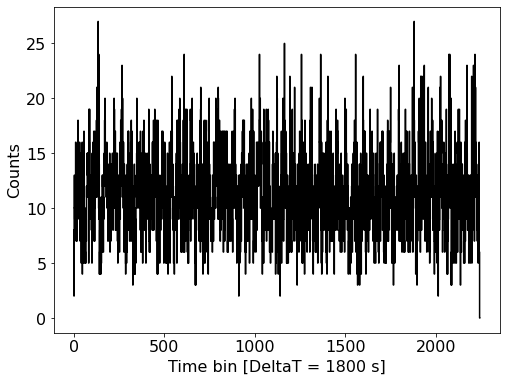

In [27]:
# lightcurve
plt.step(np.arange(n_time_bins), binned_counts, where='mid', color='k')

plt.xlabel(f'Time bin [DeltaT = {Delta_T} s]')
plt.ylabel('Counts');

## We can plot the energy spectrum directly from the cosipy analysis object.
For a single energy bin, the spectrum is necessarily a top hat in the sole non-zero bin.

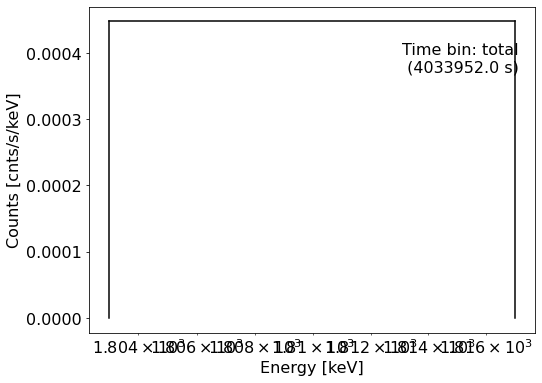

In [28]:
analysis1.dataset.plot_raw_spectrum()
plt.xscale('log')

# Define the pointing object with the cosipy pointing class.
This may also take several minutes to run.

In [29]:
# definition of poitings (balloon stability + Earth rotation)
pointing1 = Pointing(dataset=analysis1.dataset,)

# Define the BG model. 
We model the background using extensive simulations of Earth's atmospheric $\gamma$-ray background. The simulations assume the Ling model of atmospheric $\gamma$-ray emission ([Ling 1975](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JA080i022p03241), which is often adopted for this purpose in MeV $\gamma$-ray astrophysics experiments.

The simulations use an accurate mass model of the COSI-balloon instrument during flight and follow the true orientation of the instrument as it traveled along its flight path.

Notably, this background model excludes the significant background from instrumental activation. Instrumental activation refers to the excitation of instrument materials by bombarding high-energy particles, e.g. cosmic rays. The instrument materials subsequently de-excite via the emission of $\gamma$-rays which fall in COSI's energy bandpass. Often, the de-excitation lines exactly overlap with astrophysical lines of interest, including 511 keV and 1809 keV. 

A complete treatment of the background, therefore, would include both atmospheric and instrumental activation simulations. For simplicity, however, in this imaging tutorial we model only atmospheric background. Future data challenges will include instrumental activation.

In [30]:
# Ling BG simulation to model atmospheric background
background1 = BG(dataset=analysis1.dataset,
                mode='from file',
                filename='/home/jacqueline/COSItools/cosi-data-challenge-1/data_products/Scaled_Ling_BG_1x.npz')


Using background mode: from file


# Read in the response.

In [32]:
# 26Al response
rsp = response.SkyResponse(
   filename='/home/jacqueline/COSItools/cosi-data-challenge-1/data_products/1809keV_imaging_response.npz', pixel_size=pixel_size)


Reading complete continuum response. This might take a while...
Done.

You probably used a line response, there is no RMF.
If not, think again.
Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


## The shape of the response spans (Galactic latitude $b$, Galactic longitude $\ell$, Compton scattering angle $\phi$,  FISBEL, energy).

The size of each dimension depends on the chosen pixel size. Here, we've chosen $6^{\circ}$ pixels. 

Galactic latitude $b \in [-90^{\circ}, 90^{\circ}] \rightarrow$ 30 bins.\
Galactic longitude $\ell \in [-180^{\circ}, 180^{\circ}] \rightarrow$ 60 bins.\
Compton scattering angle $\phi \in [0^{\circ}, 180^{\circ}] \rightarrow$ 30 bins ("analysis1.dataset.phis.n_phi_bins").\
See above for explanation of 1145 FISBEL bins ("rsp.rsp.n_fisbel_bins").\
There is 1 energy bin in the 1809 keV response ("analysis1.dataset.energies.n_energy_bins"). This is why there is no fifth dimension for energy printed below. When using the continuum response (see point source imaging notebook), which has 10 energy bins, this cell prints (30, 60, 30, 1145, 10).

In [33]:
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145)

## The shape of the data and background objects span (time, Galactic latitude $b$, Galactic longitude $\ell$, FISBEL).

Given the time bin size "Delta_T" which we defined at the beginning of the notebook, there are 2242 time bins.

In [34]:
np.shape(analysis1.dataset.binned_data)

(2242, 1, 30, 1145)

In [35]:
np.shape(background1.bg_model)

(2242, 1, 30, 1145)

## Truncate the response at $90^{\circ}$. 
As discussed above, COSI's field of view extends $60^{\circ}$ beyond its zenith. The data/simulations themselves, however, only have hard cut manually applied at $90^{\circ}$: this is the Earth Horizon Cut (EHC). The EHC is applied to the data in order to remove background $\gamma$-ray emanating from the Earth's atmosphere below the instrument. 

To preserve any photons which may scatter in just beyond COSI's nominal $60^{\circ}$ field of view but not beyond the $90^{\circ}$ EHC, we define a "cut" which trucates, i.e. zeroes out, the response at $90^{\circ}$. 

Note that because the EHC has removed all photons beyond $90^{\circ}$, setting the cut to a value greater than $90^{\circ}$ will behave identically to cut = $90^{\circ}$.

In [48]:
cut = 90

# Choose an energy bin to analyze.
We only have one energy bin (1803-1817 keV), so the index is necessarily 0.

In [36]:
ebin = 0 

# Define a grid on the sky to make images

In [38]:
# Convenient variable for deg --> radian conversion
deg2rad = np.pi/180.

# We define our sky-grid on a regular (pixel_size x pixel_size) grid for testing (later finer grid)
binsize = pixel_size

# Galactic coordiantes: l and b pixel edges
l_arrg = np.linspace(-180, 180, int(360/binsize)+1)
b_arrg = np.linspace(-90, 90, int(180/binsize)+1)

# Number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)

# Making a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg, b_arrg)

# Choosing the centre points as representative
l_arr = l_arrg[0:-1] + binsize/2
b_arr = b_arrg[0:-1] + binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr, b_arr)

# Define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR + binsize/2)) - np.sin(np.deg2rad(B_ARR - binsize/2)))

## Convert sky grid to zenith/azimuth pairs for all pointings:

In [40]:
# calculate the zeniths and azimuths on that grid for all times
# zensgrid,azisgrid = zenaziGrid(pointing1.xpoins[:, 0], pointing1.xpoins[:, 1],
#                                pointing1.ypoins[:, 0], pointing1.ypoins[:, 1],
#                                pointing1.zpoins[:, 0], pointing1.zpoins[:, 1],
#                                L_ARR.ravel(), B_ARR.ravel())

#### 4/20/22: cosipy is rotating the source position with the above lines? don't understand...the crab
# was in the right place...
zensgrid,azisgrid = zenaziGrid(pointing1.ypoins[:,0], pointing1.ypoins[:,1],
                               pointing1.xpoins[:,0], pointing1.xpoins[:,1],
                               pointing1.zpoins[:,0], pointing1.zpoins[:,1],
                               L_ARR.ravel(), B_ARR.ravel())

In [41]:
# Reshape for next routines ... 
zensgrid = zensgrid.reshape(n_b, n_l, len(pointing1.xpoins))
azisgrid = azisgrid.reshape(n_b, n_l, len(pointing1.xpoins))

## Getting the observation indices where we actually have measured photons (important for later)

In [43]:
nonzero_idx = background1.calc_this[ebin]


## Function to get the response of an image for arbitrary time binning

In [44]:
def get_image_response_from_pixelhit_general(Response,zenith,azimuth,dt,n_hours,binsize=6,cut=60,altitude_correction=False,al=None):
    """
    Get Compton response from hit pixel for each zenith/azimuth vector(!) input.
    Binsize determines regular(!!!) sky coordinate grid in degrees.

    :param: zenith        Zenith positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :param: azimuth       Azimuth positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :option: binsize      Default 5 deg (matching the sky dimension of the response). If set
                          differently, make sure it matches the sky dimension as otherwise,
                          false results may be returned
    :option: cut          Threshold to cut the response calculation after a certain zenith angle.
                          Default 60
    :param: n_hours       Number of hours in cdxervation
    :option: altitude_correction Default False: use interpolated transmission probability, normalised to 33 km and 500 keV,
                          to modify number of expected photons as a function of altitude and zenith angle of cdxervation
    :option: al           Altitude values according to dt from construct_pointings(); used of altitude_correction is set to True
    """

    # assuming useful input:
    # azimuthal angle is periodic in the range [0,360[
    # zenith ranges from [0,180[

    # check which pixel (index) was hit on regular grid
    hit_pixel_zi = np.floor(zenith/binsize)
    hit_pixel_ai = np.floor(azimuth/binsize)

    # and which pixel centre
    hit_pixel_z = (hit_pixel_zi+0.5)*binsize
    hit_pixel_a = (hit_pixel_ai+0.5)*binsize

    # check which zeniths are beyond threshold
    bad_idx = np.where(hit_pixel_z > cut)

    # set hit pixels to output array
    za_idx = np.array([hit_pixel_zi,hit_pixel_ai]).astype(int)

    nz = zenith.shape[2]

    n_lon = int(360/binsize)
    n_lat = int(180/binsize)
    
    l_arrg = np.linspace(-180,180,int(360/binsize)+1)
    b_arrg = np.linspace(-90,90,int(180/binsize)+1)
    L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
    l_arr = l_arrg[0:-1]+binsize/2
    b_arr = b_arrg[0:-1]+binsize/2
    L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

    # take care of regular grid by applying weighting with latitude
    weights = ((binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights[bad_idx] = 0

    
    # check for negative weights and indices and remove
    weights[za_idx[0,:] < 0] = 0.
    weights[za_idx[1,:] < 0] = 0.
    za_idx[0,za_idx[0,:] < 0] = 0.
    za_idx[1,za_idx[1,:] < 0] = 0.
        
    
    if altitude_correction == True:
        altitude_response = return_altitude_response()
    else:
        altitude_response = one_func

    # get responses at pixels    
    image_response = np.zeros((n_hours,n_lat,n_lon,Response.shape[2]))

    for c in tqdm(range(n_hours)):
        cdx = np.where((pointing1.cdtpoins > analysis1.dataset.times.times_min[analysis1.dataset.times.n_ph_dx[c]]) &
                       (pointing1.cdtpoins <= analysis1.dataset.times.times_max[analysis1.dataset.times.n_ph_dx[c]]))[0]
    
        # this calculation is basically a look-up of the response entries. In general, weighting (integration) with the true shape can be introduced, however with a lot more computation time (Simpson's rule in 2D ...)
        image_response[c,:,:,:] += np.sum(Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:]*np.einsum('klij->iklj', weights[:,:,cdx,None])*dt[cdx,None,None,None],axis=0)#*altitude_weights[:,:,None]
        
    return image_response


# ??? Reduce the response dimensions

In [45]:
sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
    n_b,
    n_l,
    analysis1.dataset.phis.n_phi_bins*\
    analysis1.dataset.fisbels.n_fisbel_bins, analysis1.dataset.energies.n_energy_bins)[:, :, nonzero_idx, ebin]

In [46]:
# reduced response dimensions:
# lat x lon x CDS
sky_response_CDS.shape

(30, 60, 3163)

# Calculation of the general response for the current data set.
This has to be done only once (for the data set).

Takes ~40 minutes to run and ~100 GB memory!

In [49]:
sky_response_scaled = get_image_response_from_pixelhit_general(
    Response=sky_response_CDS,
    zenith=zensgrid,
    azimuth=azisgrid,
    dt=pointing1.dtpoins,
    n_hours=analysis1.dataset.times.n_ph,
    binsize=pixel_size,
    cut=cut,
    altitude_correction=False,
    al=np.ones(len(pointing1.dtpoins)))

In [50]:
# data-set-specific response dimensions
# times x lat x lon x CDS
sky_response_scaled.shape

(2242, 30, 60, 3163)

# Calculation of the "exposure map," i.e. the response weighted by time

In [51]:
expo_map = np.zeros((n_b, n_l))

for i in tqdm(range(sky_response_scaled.shape[0])):
    expo_map += np.sum(sky_response_scaled[i,:,:,:], axis=2)
    
print(f'expo_map shape: {expo_map.shape}')


expo_map shape: (30, 60)


## Plotting the exposure map weighted with the pixel size

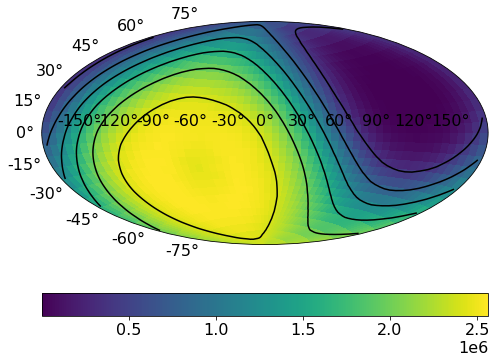

In [52]:
plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.roll(expo_map/domega,axis=1,shift=0))
plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.roll(expo_map/domega,axis=1,shift=0),colors='black')
plt.colorbar(p, orientation='horizontal')

# Imaging
Set up the Richardson-Lucy deconvolution algorithm.

### Define regions of the sky that we actually cannot see

In [53]:
# here we select everything, i.e. we have no bad exposure

bad_expo = np.where(expo_map/domega <= 0)

### Define function for a starting map for the RL deconvolution. We choose an isotropic map, i.e. all pixels on the sky are initialized with the same value

In [1]:
def IsoMap(ll,bb,A0,binsize=pixel_size):
    shape = np.ones(ll.shape)
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

NameError: name 'pixel_size' is not defined

### Number of time bins (should be the first dimension of the response)

In [72]:
d2h = n_time_bins 
d2h

2242

### Select only one energy bin (as above) for data set

In [73]:
print('ebin: ',ebin)
dataset = analysis1.dataset.binned_data[:,ebin,:,:].reshape(d2h,
                                                            analysis1.dataset.phis.n_phi_bins*analysis1.dataset.fisbels.n_fisbel_bins)[:,nonzero_idx]


ebin:  0


### Same for background

In [74]:
background_model = background1.bg_model_reduced[ebin]

### Check for consistency of data and background
They must have the same dimensions. If not, the algorithm won't work.

In [75]:
dataset.shape, background_model.shape

((2242, 3163), (2242, 3163))

### Define background model cuts, indices, and resulting number of cuts

In [76]:
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts

### For the modified RL algorithm implemented here, we need to load a stan model that fits background plus two images (the current image plus a delta image given by the RL formalism)

# Ask Thomas: I just copied this .stan file from COSIpy and have been using it for all imaging. We have to upload this .stan file to the DC, right?

In [60]:
#read filename.pkl (if already compiled)
# this might not work for you, let me know if there is a problem here

try:
    #read COSImodefit.pkl (if already compiled)
    model_multimap = pickle.load(open('fit_COSI_conved_2D_multimap_indivBG.pkl', 'rb'))

except:
    print('Model not yet compiled, doing that now (might take a while).')
    
    # compile model (if not yet compiled):
    model_multimap = pystan.StanModel('fit_COSI_conved_2D_multimap_indivBG.stan')

    with open(data_dir + 'fit_COSI_conved_2D_multimap_indivBG_continuum_rsp_ebin2.pkl', 'wb') as f:
        pickle.dump(model_multimap, f)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2390c79fba64c04b17c25d7ffa1173f NOW.


Model not yet compiled, doing that now (might take a while).


In file included from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_o0_tihmd/stanfit4anon_model_f2390c79fba64c04b17c25d7ffa1173f_2495205300421351726.cpp:696:
/home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/

## Read in contours from a real tracer of $^{26}$Al to plot over our RL image
Read in the DIRBE 240$\mu$m map (a far-infrared survey considered to be a good tracer of $^{26}$Al emission) as a FITS file, rebin it to $6^{\circ} \times 6^{\circ}$ resolution, and plot contours over the RL iterations below.

In [62]:
def bin_ndarray(ndarray, new_shape, operation="sum"):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation=‘sum’)
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

In [63]:
from astropy.io import fits

In [64]:
dirbe_1deg = fits.open('/home/jacqueline/COSIpy_DC1/SPI_DIRBE_Orig_Knoedl_240um.fits')
data = dirbe_1deg[2].data

# interpolate to (360, 720)
from scipy.ndimage.interpolation import map_coordinates
new_dims = []
for original_length, new_length in zip(data.shape, (360, 720)):
    new_dims.append(np.linspace(0, original_length-1, new_length))
    
coords = np.meshgrid(*new_dims, indexing='ij')
B = map_coordinates(data, coords)
B.shape

dirbe_6deg_6deg = bin_ndarray(B, (30, 60), 'mean')
dirbe_6deg_6deg = np.flip(dirbe_6deg_6deg)

## Set an initial guess for the background amplitude
Feel free to play with this value, but here are suggestions informed by testing thus far:

### If source+BG:
We suggest setting "fitted_bg" to 0.9 or 0.99 when the loaded data/simulation (analysis1 object) contains both source and background. This is a rough estimate of the background contribution (90, 99%) to the entire data set.

### If analyzing source only:
When the analysis1 object does not contain background, we suggest setting this parameter to 1E-6, i.e. very close to zero background contribution.

In [68]:
fitted_bg = np.array([0.9])


# Richardson-Lucy algorithm

## Individual steps are explained in code.
The steps follow the algorithm as outlined in [Knödlseder et al. 1999](https://ui.adsabs.harvard.edu/abs/1999A%26A...345..813K/abstract). Refer to that paper for a mathematical description of the algorithm.

The total memory used during these iterations is about 108 GB!! You might not be able to do much else with your machine while this is running. 

## Adjustable parameters
There are three parameters at the beginning of this RL cell which we encourage you to adjust. In fact, it is often necessary to adjust these parameters depending on the data being studied.

- map_init\
This is the flux value of the initial, isotropic map. Typically, a value of 0.01 works well. For stronger sources, you can try increasing it to 0.1 or 1.0. As an example, running the algorithm on a source-only (no BG) simulation of the Crab, Cen A, Cygnus X-1, and Vela works well with map_init = 0.01. However, when imaging these sources each simulated with 10X their true flux values, the algorithm fails at 0.01 and work when map_init = 1.0.

- iterations\
This is the number of RL iterations. You can set this to a small value, say 50, as you get used to using the algorithm. In our testing, though, for fully converged images we usually let the algorithm run for 150 iterations. ***This can take anywhere from several hours (usually simulations without background) to overnight (simulations with background) to run.***

- afl_scl\
This is a scaling factor for the delta map which we call the "acceleration parameter." This allows the delta map to be afl_scl times stronger than the original RL algorithm suggests (c.f. Knoedlseder+1997).\
The default value here is 2000, though 1000 also works well. If you find that the algorithm returns "Fit failed" messages after running for awhile, for example, lowering this acceleration parameter to 1000 can help.

Other parameters you can adjust:
- mu_Abg, sigma_Abg\
There is a prior in the background fit defined by mu_Abg +/- sigma_Abg. By default, mu_Abg and sigma_Abg are set to fitted_bg and most testing has been done with this setting. You can try constraining the fit by decreasing sigma_Abg, for example, to sigma_Abg/2., sigma_Abg/10., which would enable to fit to vary by 50%, 10% of the initial guess.

- delta_map_tot_old\
You can change the exponent of the denominator. By default, it is set to 0.25 to help avoid exposure edge effects. All testing has been done with this fourth root. However, you can try setting it to 0, 0.5, etc. to see what happens. You can also try smoothing delta_map_tot_old with a Gaussian filter.

In [69]:
# Might not use this depending on if you choose to smooth the delta map
from scipy.ndimage import gaussian_filter

Convolving with response (init expectation), iteration 0


Calculating Delta image, iteration 1, numerator


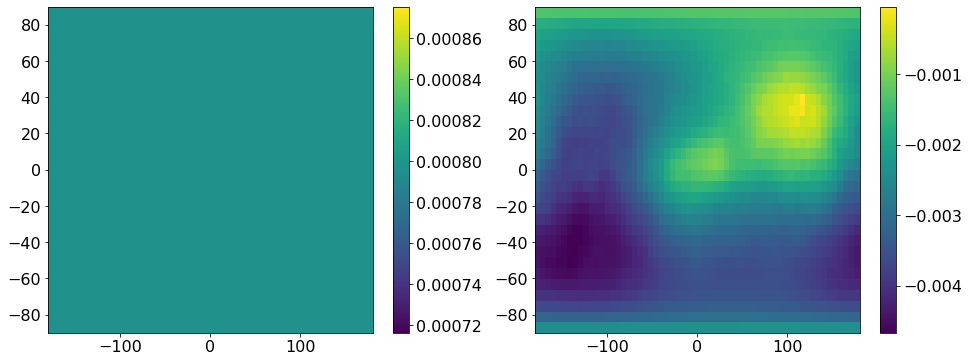

Convolving Delta image, iteration 1



Finding maximum acceleration parameter, iteration 1
Maximum acceleration parameter found:  0.17
Fitting delta-map in addition to old map, iteration 1
Saving new map, and fitted parameters, iteration 1
Calculating Delta image, iteration 2, numerator


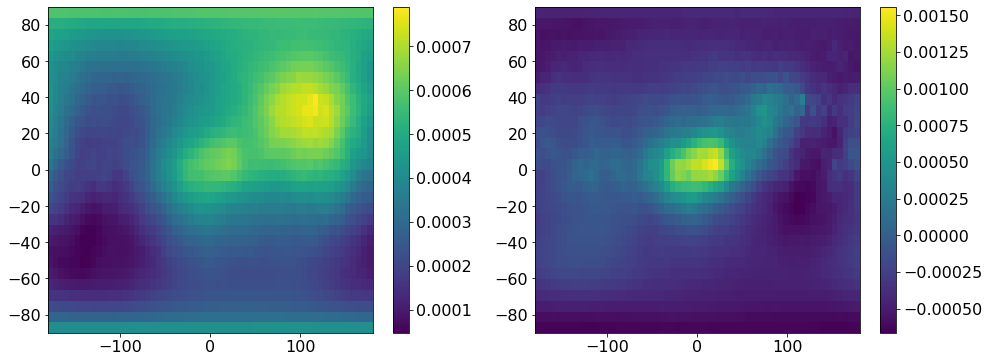

Convolving Delta image, iteration 2



Finding maximum acceleration parameter, iteration 2
Maximum acceleration parameter found:  0.349
Fitting delta-map in addition to old map, iteration 2
Saving new map, and fitted parameters, iteration 2
Calculating Delta image, iteration 3, numerator


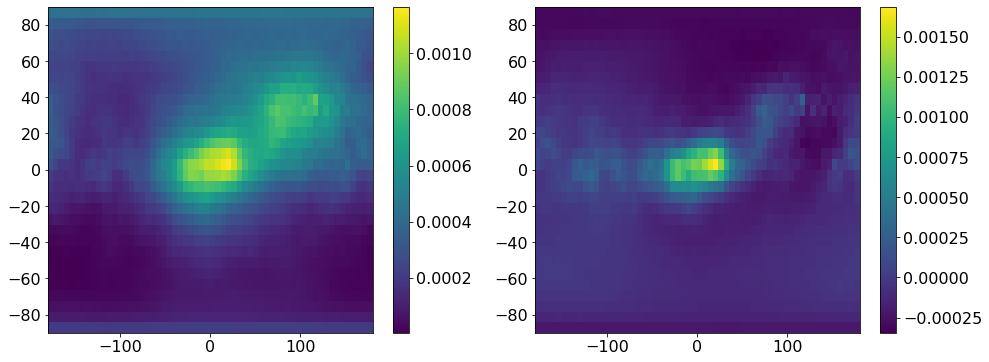

Convolving Delta image, iteration 3



Finding maximum acceleration parameter, iteration 3
Maximum acceleration parameter found:  0.509
Fitting delta-map in addition to old map, iteration 3
Saving new map, and fitted parameters, iteration 3
Calculating Delta image, iteration 4, numerator


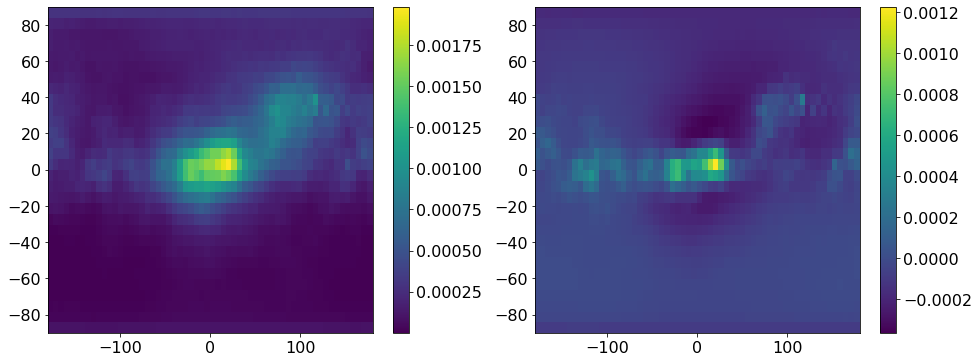

Convolving Delta image, iteration 4



Finding maximum acceleration parameter, iteration 4
Maximum acceleration parameter found:  0.562
Fitting delta-map in addition to old map, iteration 4
Saving new map, and fitted parameters, iteration 4
Calculating Delta image, iteration 5, numerator


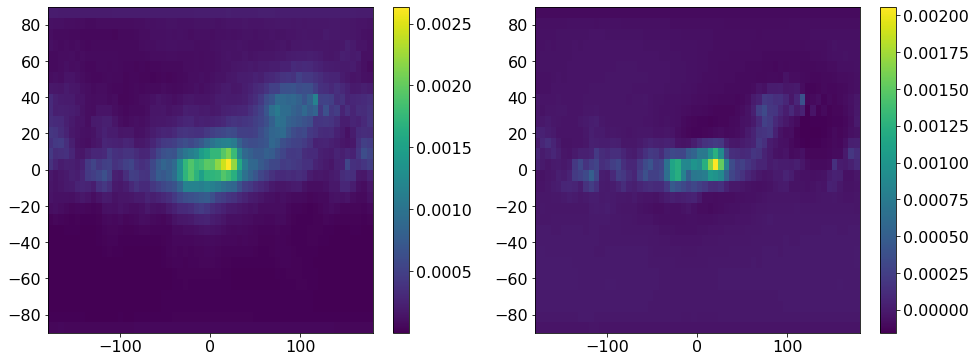

Convolving Delta image, iteration 5



Finding maximum acceleration parameter, iteration 5
Maximum acceleration parameter found:  0.577
Fitting delta-map in addition to old map, iteration 5
Saving new map, and fitted parameters, iteration 5
Calculating Delta image, iteration 6, numerator


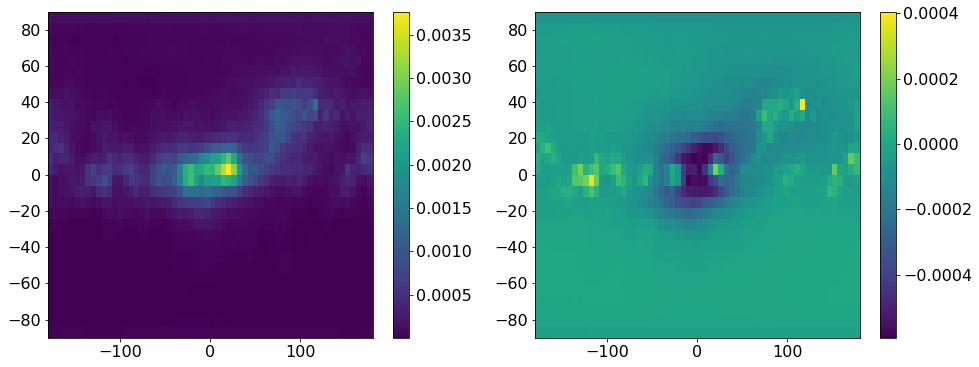

Convolving Delta image, iteration 6



Finding maximum acceleration parameter, iteration 6
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 6
Saving new map, and fitted parameters, iteration 6
Calculating Delta image, iteration 7, numerator


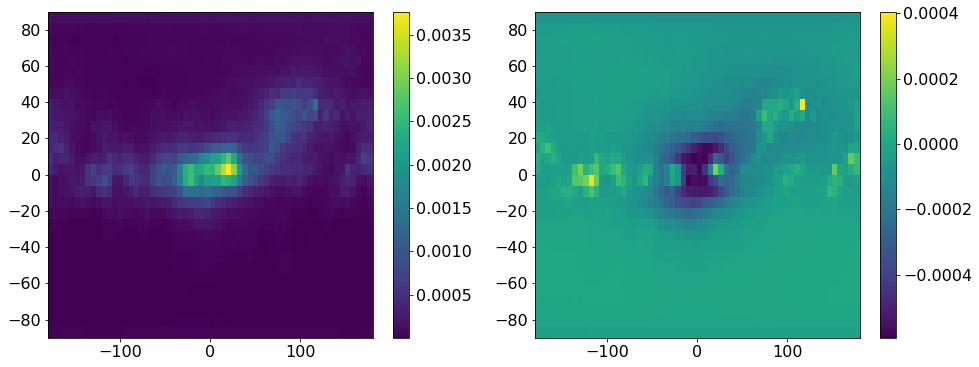

Convolving Delta image, iteration 7



Finding maximum acceleration parameter, iteration 7
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 7
Saving new map, and fitted parameters, iteration 7
Calculating Delta image, iteration 8, numerator


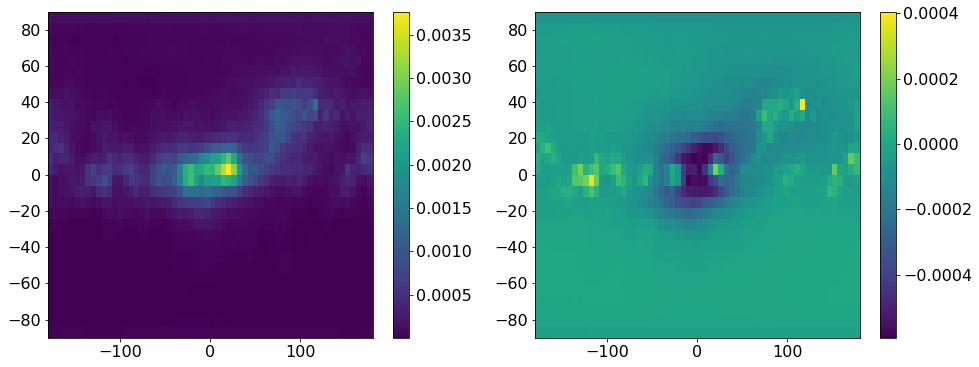

Convolving Delta image, iteration 8



Finding maximum acceleration parameter, iteration 8
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 8
Saving new map, and fitted parameters, iteration 8
Calculating Delta image, iteration 9, numerator


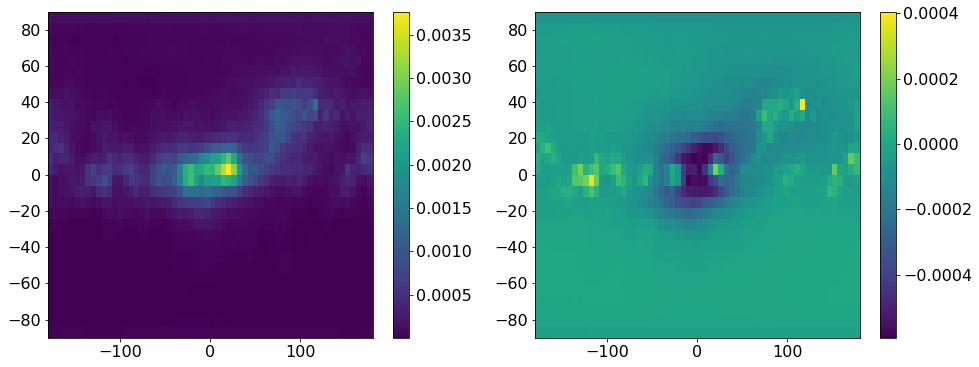

Convolving Delta image, iteration 9



Finding maximum acceleration parameter, iteration 9
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 9
Saving new map, and fitted parameters, iteration 9
Calculating Delta image, iteration 10, numerator


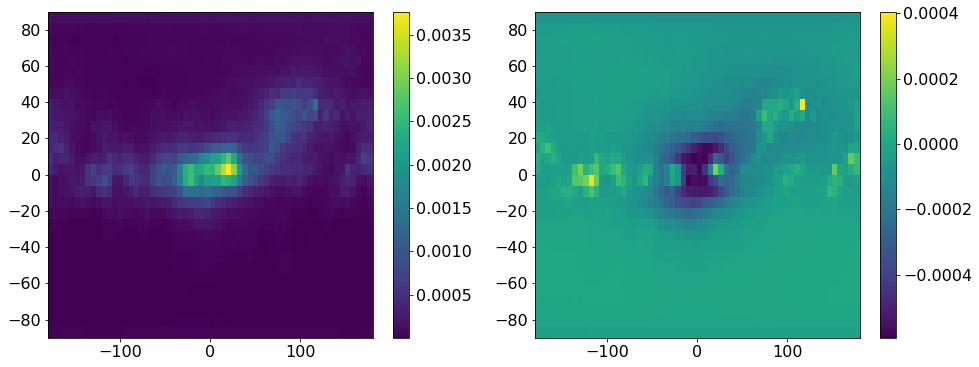

Convolving Delta image, iteration 10



Finding maximum acceleration parameter, iteration 10
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 10
Saving new map, and fitted parameters, iteration 10
Calculating Delta image, iteration 11, numerator


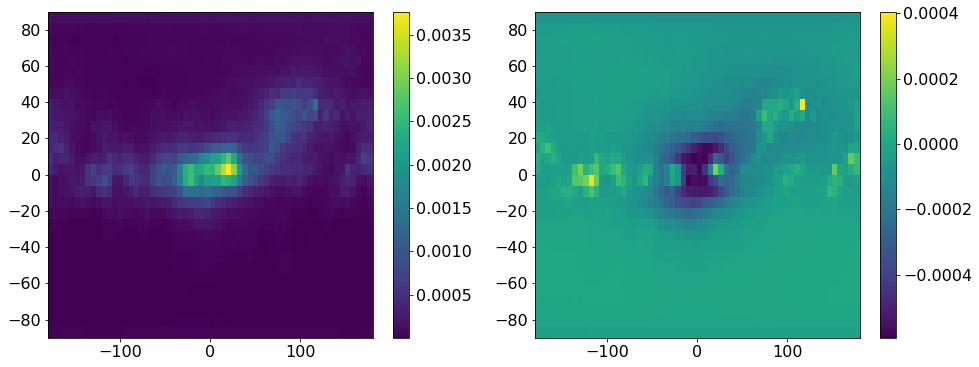

Convolving Delta image, iteration 11



Finding maximum acceleration parameter, iteration 11
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 11
Saving new map, and fitted parameters, iteration 11
Calculating Delta image, iteration 12, numerator


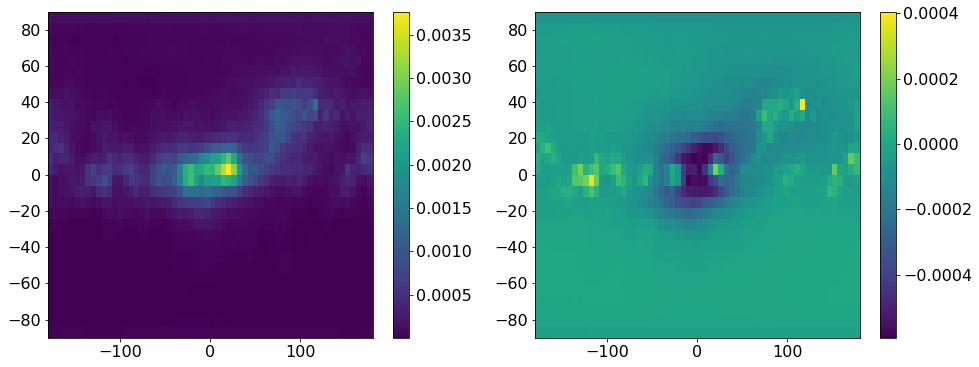

Convolving Delta image, iteration 12



Finding maximum acceleration parameter, iteration 12
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 12
Saving new map, and fitted parameters, iteration 12
Calculating Delta image, iteration 13, numerator


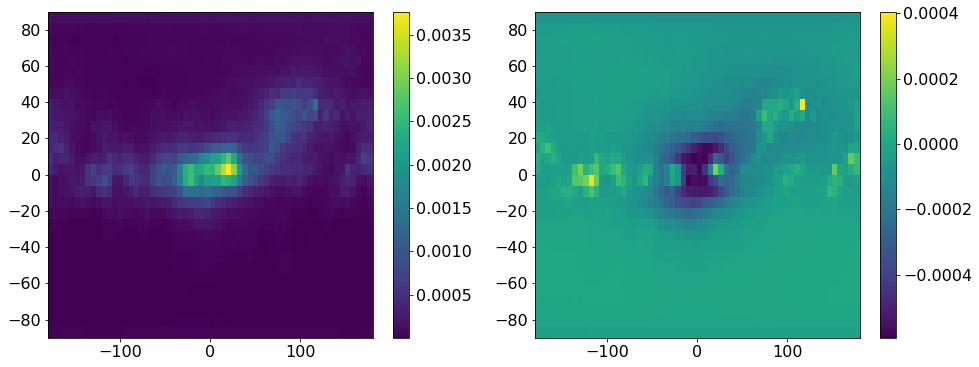

Convolving Delta image, iteration 13



Finding maximum acceleration parameter, iteration 13
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 13
Saving new map, and fitted parameters, iteration 13
Calculating Delta image, iteration 14, numerator


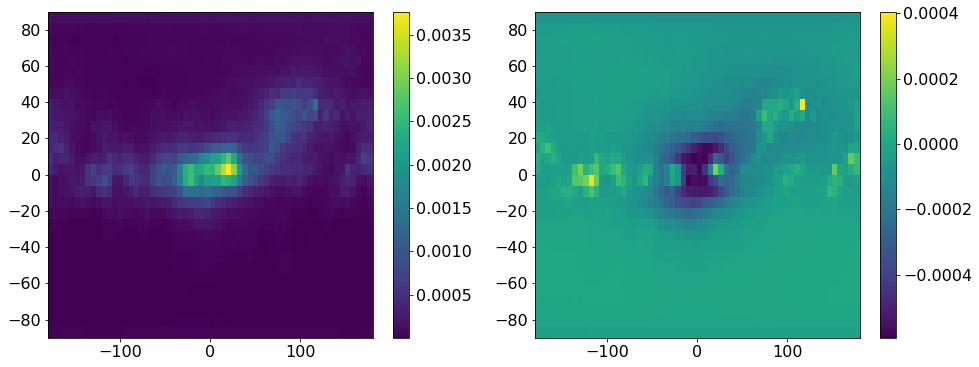

Convolving Delta image, iteration 14



Finding maximum acceleration parameter, iteration 14
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 14
Saving new map, and fitted parameters, iteration 14
Calculating Delta image, iteration 15, numerator


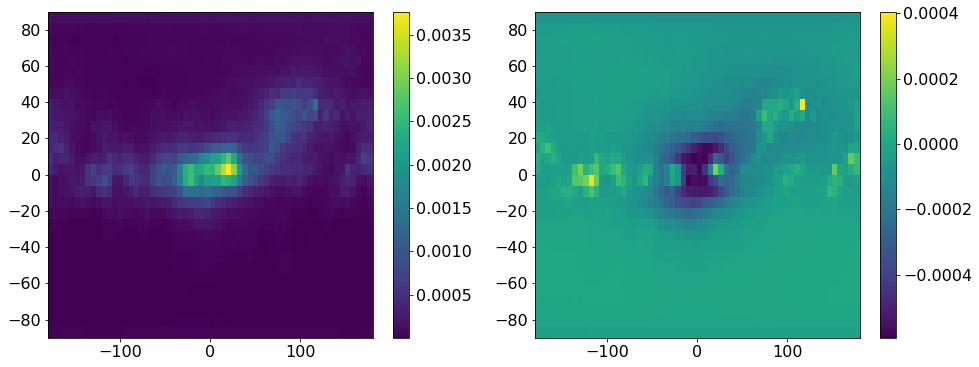

Convolving Delta image, iteration 15



Finding maximum acceleration parameter, iteration 15
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 15
Saving new map, and fitted parameters, iteration 15
Calculating Delta image, iteration 16, numerator


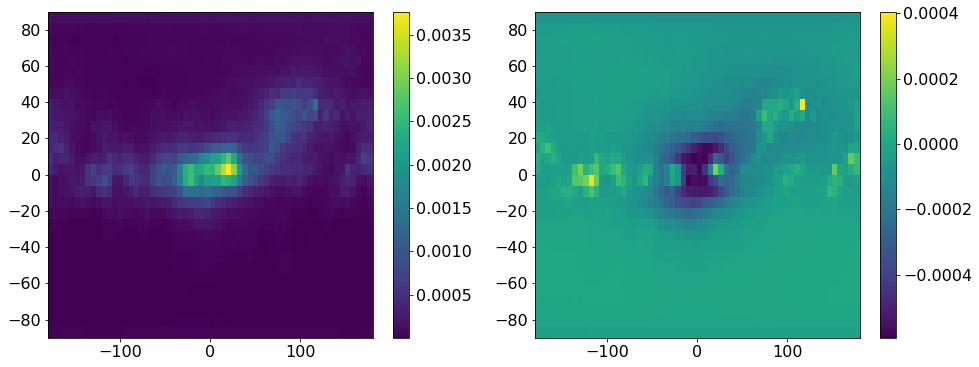

Convolving Delta image, iteration 16



Finding maximum acceleration parameter, iteration 16
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 16
Saving new map, and fitted parameters, iteration 16
Calculating Delta image, iteration 17, numerator


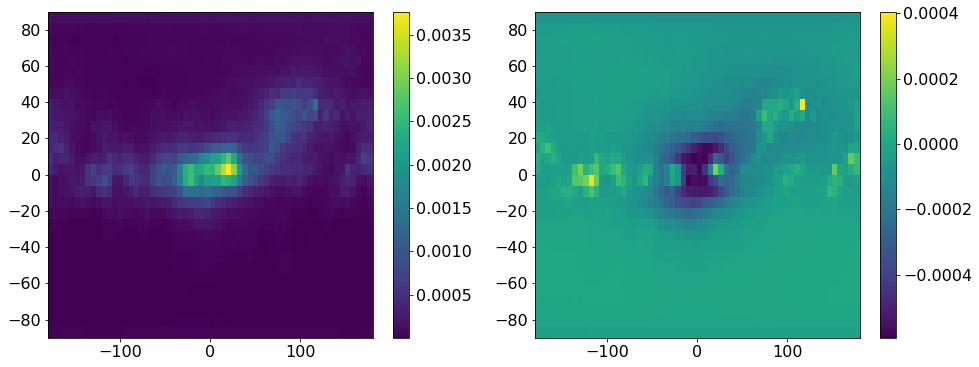

Convolving Delta image, iteration 17



Finding maximum acceleration parameter, iteration 17
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 17
Saving new map, and fitted parameters, iteration 17
Calculating Delta image, iteration 18, numerator


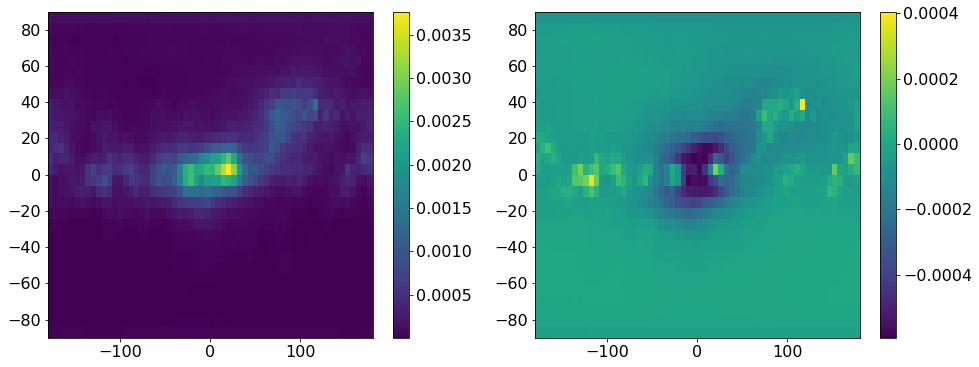

Convolving Delta image, iteration 18



Finding maximum acceleration parameter, iteration 18
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 18
Saving new map, and fitted parameters, iteration 18
Calculating Delta image, iteration 19, numerator


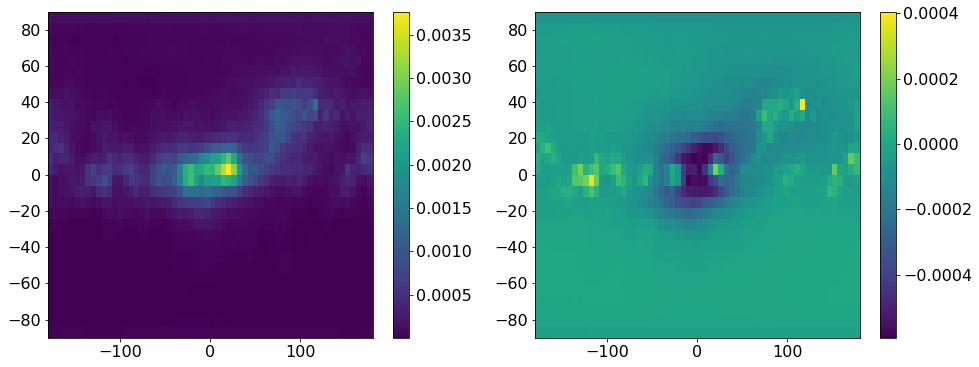

Convolving Delta image, iteration 19



Finding maximum acceleration parameter, iteration 19
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 19
Saving new map, and fitted parameters, iteration 19
Calculating Delta image, iteration 20, numerator


KeyboardInterrupt: 

Initial log joint probability = -155702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: poisson_lpmf: Rate parameter[1] is -0.000346005, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)

Exception: poisson_lpmf: Rate parameter[1] is -0.000165049, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)


      19       -155086      0.204902       8.35759           1           1       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      26       -155086    0.00316623     0.0071323           1           1       33   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -155010
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -154924      0.430687       14.0062      0.3141           1       23  

In [77]:
# Experiment with these variables!
#############################
# initial map (isotropic flat, small value)
map_init = IsoMap(L_ARR, B_ARR, 0.01)

# number of RL iterations, Usually test with ~150 iterations. 
iterations = 150 

# acceleration parameter
afl_scl = 2000.
#############################


## Define background (to be sure it's the same as before)
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
 
    
## Save intermediate iterations: initialise arrays to save images and other parameters
# maps per iteration
map_iterations = np.zeros((n_b, n_l, iterations))

# likelihood of maps (vs. initial i.e. basically only background)
map_likelihoods = np.zeros(iterations)

# fit likelihoods, ie fit quality
intermediate_lp = np.zeros(iterations)

# acceleration parameters (lambda)
acc_par = np.zeros(iterations)

# fitted background parameters 
bg_pars = np.zeros((iterations,Ncuts))


## Zeroth iteration: copy initial map to become the 'old map' (see below)
map_old = map_init

# cf. Knoedlseder+1997 what the values denominator etc are
# this is the response R summed over the CDS and the time bins
denominator = expo_map

# zeroth iteration is then just the initial map
map_iterations[:,:,0] = map_old#[]

# convolve this map with the response
expectation_init = 0
print('Convolving with response (init expectation), iteration 0')
for i in tqdm(range(n_b)):
    for j in range(n_l):
        expectation_init += sky_response_scaled[:,i,j,:]*map_init[i,j]

# set old expectation (in data space bins) to new expectation (convolved image)
expectation_old = expectation_init

### now we have the expectation of the image. Need to go to the BG 
        
###########################################################
###########################################################
## here run over the number of iterations #################
###########################################################
## the time for the convolutions is very large ############
## this can be 10 minutes (!) per iteration ###############
## this should be tested for a few iterations #############
## and then run overnight or similar ######################
###########################################################
###########################################################
for its in tqdm(range(1,iterations)):
    
    # setting the map to zero where we selected a bad exposure (we didn't, but to keep it general)
    map_old[bad_expo[0],bad_expo[1]] = 0
    
    # check for each pixel to be finite
    map_old[np.where(np.isnan(map_old) == True)] = 0
    
    # make new background for the next iteration
    bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
    
    # temporary background model
    tmp_model_bg = np.zeros((d2h,background1.bg_model_reduced[ebin].shape[1]))
    
    # there could be something different for the first iteration (here it isn't, same function call)
    if its == 1:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
    else:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
            
    # expectation (in data space) is the image (expectation_old) plus the background (tmp_model_bg)
    expectation_tot_old = expectation_old + tmp_model_bg 

    # calculate likelihood of currect total expectation
    map_likelihoods[its-1] = cashstat(dataset.ravel(),expectation_tot_old.ravel())
    
    # calculate numerator of RL algorithm
    numerator = 0
    print('Calculating Delta image, iteration '+str(its)+', numerator')
    for i in tqdm(range(d2h)):
        for j in range(dataset.shape[1]):
            numerator += (dataset[i,j]/expectation_tot_old[i,j]-1)*sky_response_scaled[i,:,:,j]
    
    # calculate delta map (denominator scaled by fourth root to avoid exposure edge effects)
    # You can try changing 0.25 to 0, 0.5, for example
    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.25
    
    # Alternatively, you can also try to smooth it 
    #delta_map_tot_old = gaussian_filter(delta_map_tot_old, 0.5)
    
    #################################
    
    
    
    # check again for finite values and zero our bad exposure regions
    nan_idx = np.where(np.isnan(delta_map_tot_old) == 1)
    delta_map_tot_old[nan_idx[0],nan_idx[1]] = 0
    delta_map_tot_old[bad_expo[0],bad_expo[1]] = 0

    # plot each iterations and its delta map 
    # (not required, but nice to see how the algorithm is doing)
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(map_old, axis=1, shift=0)) 
    plt.colorbar()

    plt.subplot(122)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(delta_map_tot_old, axis=1, shift=0)) 
    plt.colorbar()
    plt.show()
    
    # convolve delta image
    print('Convolving Delta image, iteration '+str(its))
    conv_delta_map_tot = 0
    for i in tqdm(range(n_b)):
        for j in range(n_l):
            conv_delta_map_tot += sky_response_scaled[:,i,j,:]*delta_map_tot_old[i,j]
    
    # find maximum acceleration parameter to multiply delta image with
    # so that the total image is still positive everywhere
    print('Finding maximum acceleration parameter, iteration '+str(its))
    try:
        len_arr = []
        for i in range(0,10000):
            len_arr.append(len(np.where((map_old+delta_map_tot_old*i/afl_scl) < 0)[0]))
        len_arr = np.array(len_arr)
        afl = np.max(np.where(len_arr == 0)[0])
        print('Maximum acceleration parameter found: ',afl/afl_scl)

        
        # fit delta map and current map to speed up RL algorithm
        print('Fitting delta-map in addition to old map, iteration '+str(its))
        # dictionary for data set and prior
        # note that here the value for N should be your response CDS dimension
        # should be last dimension of the scaled response thing (change to your value)
        data_multimap = dict(N = dataset.shape[1],
                     Nh = d2h,
                     Ncuts = Ncuts,
                     Nsky = 2,
                     acceleration_factor_limit=afl*0.95,
                     bg_cuts = bg_cuts,
                     bg_idx_arr = idx_arr,
                     y = dataset.ravel().astype(int),
                     bg_model = tmp_model_bg,
                     conv_sky = np.concatenate([[expectation_old],[conv_delta_map_tot/afl_scl]]),
                     mu_flux = np.array([1,afl/2]),
                     sigma_flux = np.array([1e-2,afl]),
                     mu_Abg = fitted_bg,    # can play with this
                     sigma_Abg = fitted_bg) # can play with this

        # fit;
        # initial values for fit (somewhat sensitive here with COSI data)
        init = {}
        init['flux'] = np.array([1.,afl/2.])
        init['Abg'] = np.repeat(fitted_bg, Ncuts) # can play with this
        
        # fit: might take some time but it shouldn't be more than a minute
        op2D = model_multimap.optimizing(data=data_multimap,init=init,as_vector=False,verbose=True,
                                                tol_rel_grad=1e3,tol_obj=1e-20)

        # save values
        print('Saving new map, and fitted parameters, iteration '+str(its))
        intermediate_lp[its-1] = op2D['value']
        acc_par[its-1] = op2D['par']['flux'][1]
        bg_pars[its-1,:] = op2D['par']['Abg']
  
        # make new map as old map plus scaled delta map
        map_new = map_old+op2D['par']['flux'][1]*delta_map_tot_old/afl_scl
    
        # same with expectation (data space)
        expectation_new = expectation_old + op2D['par']['flux'][1]*conv_delta_map_tot/afl_scl
        

    except:
        # if the fit failed...
        # this shouldn't happen too often (or at all)
        print('############## Fit failed! proceeding without acceleration ##############')
        map_new = map_old + delta_map_tot_old
        expectation_new = expectation_old + conv_delta_map_tot
    
    # check finite values again
    if its == 1:
        bad_index_init = np.where(np.isnan(map_new) == True)
    
    # also here
    map_new[bad_expo[0],bad_expo[1]] = 0
    map_new[np.where(np.isnan(map_new) == True)] = 0
    map_iterations[:,:,its] = map_new

    # swap maps
    map_old = map_new
    
    # and expectations
    expectation_old = expectation_new
    
    # and repeat


## Plot the fitted background parameter and the map flux

Text(0, 0.5, 'Flux')

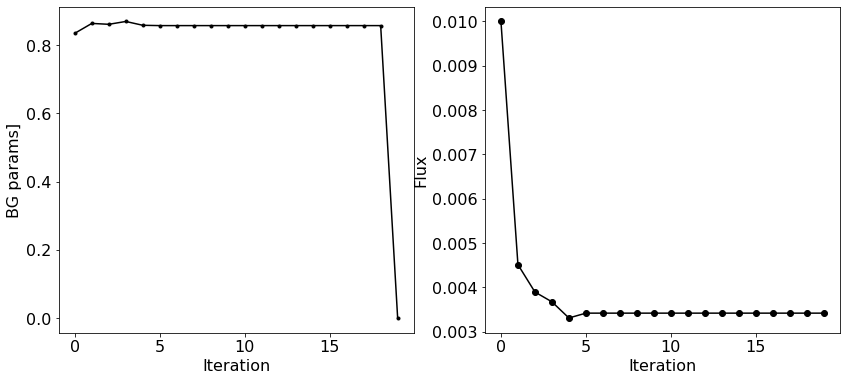

In [78]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its), [i[0] for i in bg_pars[:its]], '.-')
plt.xlabel('Iteration')
plt.ylabel('BG params]')


plt.subplot(122)
map_fluxes = np.zeros(its)
for i in range(its):
    map_fluxes[i] = np.sum(map_iterations[:,:,i]*domega)
    
plt.plot(map_fluxes[:its],'o-')
plt.xlabel('Iteration')
plt.ylabel('Flux')# [ph/keV]')

## Did the algorithm converge? Look at the likelihoods.
intermediate_lp: Fit likelihoods, i.e. fit quality

map_likelihoods: likelihood of maps (vs. initial i.e. basically only background)

Text(0, 0.5, 'likelihood (map_likelihoods)')

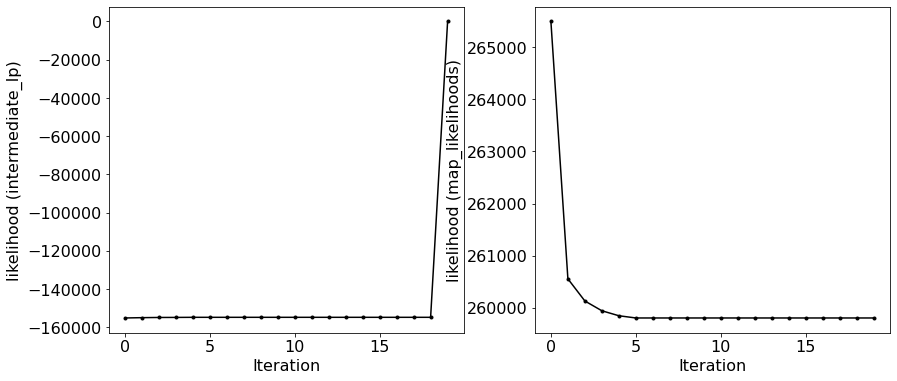

In [79]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its+1)[:-1], intermediate_lp[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (intermediate_lp)')

plt.subplot(122)
plt.plot(range(its+1)[:-1], map_likelihoods[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (map_likelihoods)')


## Make the image!
You can loop over all iterations to make a GIF or just show one iteration (usually the final iteration).

In [80]:
from IPython.display import Image
from IPython.display import Video
from tqdm.autonotebook import tqdm

from matplotlib import animation

from matplotlib import colors

from scipy.ndimage import gaussian_filter as smooth

In [85]:
# Choose an image to plot
idx = its - 1


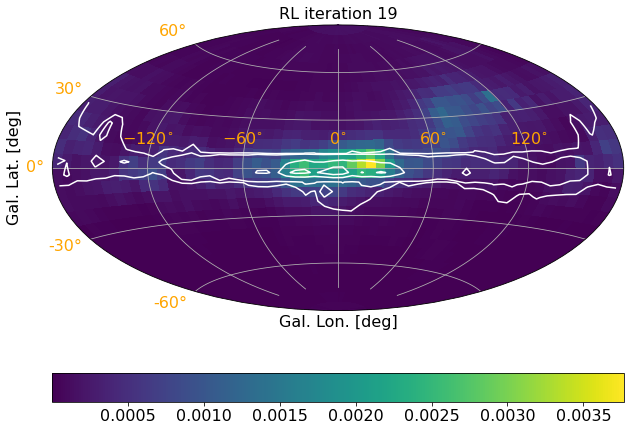

In [86]:
# Choose a color map like viridis (matplotlib default), nipy_spectral, twilight_shifted, etc. Not jet.
cmap = plt.get_cmap('viridis') 

# Bad exposures will be gray
cmap.set_bad('lightgray')


##################
# Select here which pixels should be gray
map_iterations_nan = np.copy(map_iterations)

# Select also non-zero exposures here to be gray (avoiding the edge effects)
# You can play with this. Most success in testing with 1e4, 1e3
bad_expo = np.where(expo_map/domega <= 1e3) 

for i in range(iterations):
    map_iterations_nan[bad_expo[0], bad_expo[1], i] = np.nan
#################    


# Set up the plot
fig, ax = plt.subplots(figsize=(10.24,7.68), subplot_kw={'projection':'aitoff'}, nrows=1, ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.tick_params(axis='x', colors='orange')

ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')


# Optionally plot contours from the DIRBE 240um image
levels = [np.max(dirbe_6deg_6deg)*0.05, np.max(dirbe_6deg_6deg)*0.1,
          np.max(dirbe_6deg_6deg)*0.5, np.max(dirbe_6deg_6deg)*0.8]
plt.contour(L_ARR*deg2rad, B_ARR*deg2rad, dirbe_6deg_6deg, levels=levels, colors='white', alpha=1)


# "ims" is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []


# If you want to make a GIF of all iterations:
#for i in range(iterations):

# If you only want to plot one image:
for i in [idx]:

    ttl = plt.text(0.5, 1.01, f'RL iteration {i}', horizontalalignment='center', 
                   verticalalignment='bottom', transform=ax.transAxes)
    
    # Either gray-out bad exposure (map_iterations_nan) or don't mask (map_iterations)
    # Masking out bad exposure 
    #image = map_iterations_nan[:, :, i]
    image = map_iterations[:, :, i]

    
    img = ax.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
                        
                        # Can shift the image along longitude. Here, no shift.
                        np.roll(image, axis=1, shift=0),
            
                        # Optionally smooth with gaussian filter
                        #smooth(np.roll(image, axis=1, shift=0), 0.75/pixel_size),
                        
                        cmap=plt.cm.viridis,
                        
                        # Optionally set the color scale. Default: linear
                        #norm=colors.PowerNorm(0.33)
                       )
    ax.grid()
    
    ims.append([img, ttl])

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    

# Can save a sole image as a PDF 
#plt.savefig(data_dir + f'images/26Al_RL_image_iteration{idx}.pdf', bbox_inches='tight')
    
    
# # Can save all iterations as a GIF
# ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=0)
# ani.save(f'/home/jacqueline/26Al_RL_image_{idx}iterations.gif')


# What do we see?

As expected, we observe extended $^{26}$Al emission along the Galactic Plane. There is concentrated emission in the Inner Galaxy. The RL algorithm therefore behaves as expected, placing photons simulated along the DIRBE 240$\mu$m template map within the contours of this chosen tracer of $^{26}$Al emission.

Given that only $\sim$100 $^{26}$Al photons were detected during the COSI-balloon flight ($3.7\sigma$ significance, [Beechert et al. 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac56dc/meta)), imaging the emission at its true flux instead of 10x strength would likely result in only imaging artifacts. Consider the following calculation. For $n$ spatial bins each with measurement significance $n_i$, the total significance of a measurement is 

$s = (\sum_{i = 1}^{n} s_i^2)^{1/2}$.

Even requiring only a weak $2\sigma$ measurement in each bin, the maximum $n$ number of bins for a total $3.7\sigma$ measurement is approximately 3.4. In other words, a $3.7\sigma$ significant measurement distributed across the broad, diffuse $^{26}$Al emission which spans the Galactic Plane would result in few spatial bins with discernable significance. 

Below, we fit the simulated 10x flux image with a 2-D Gaussian as a demonstration of efforts to characterize the morphology of Galactic $^{26}$Al. 

Future data challenges will image $^{26}$Al as seen with the COSI satellite. Increased observation time, increased effective area, finer angular resolution, and observations at high Galactic latitudes (extending above and below the Galactic Plane) have great potential to advance understanding of this radioisotope.

In [87]:
# fit a 2D Gaussian to the emission

In [88]:
def gauss_2d(xtuple, A, x0, y0, sigma_x, sigma_y, theta):
    # theta: rotate the blob by positive, counterclockwise angle theta
    (x, y) = xtuple
    x0 = float(x0)
    y0 = float(y0)
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = np.sin(2*theta)/(4*sigma_x**2) - np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    tot = A*np.exp( -( a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2 ) )
    return tot.ravel()

In [90]:
import scipy.optimize as opt
initial_guess = (2, 0, 0, 10, 10, 4)
x = (L_ARRg*deg2rad)[:-1, :-1]
y = (B_ARRg*deg2rad)[:-1, :-1]
z = map_iterations_nan[:, :, idx]
nan = np.isnan(z)
z[nan] = 0.
popt, pcov = opt.curve_fit(gauss_2d, (x, y), z.ravel(), p0=initial_guess)

im_fitted = gauss_2d((x, y), *popt)

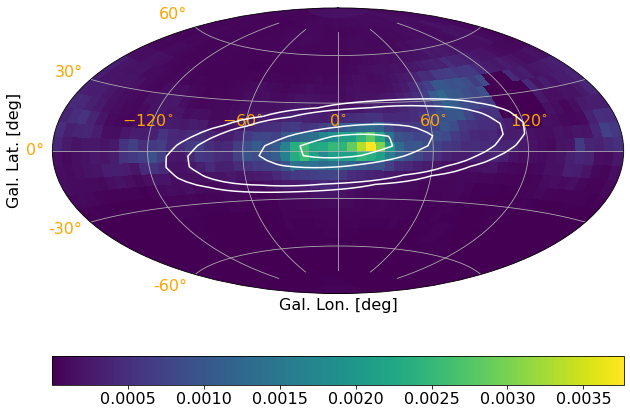

In [97]:
fig, ax = plt.subplots(figsize=(10.24, 7.68), subplot_kw={'projection':'aitoff'}, nrows=1, ncols=1)

ax.set_xticks(np.array([-120, -60, 0, 60, 120])*deg2rad)
ax.tick_params(axis='x', colors='orange')
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

ax.set_xlabel('Gal. Lon. [deg]')
ax.set_ylabel('Gal. Lat. [deg]')

# Plot original image
ax.pcolormesh(L_ARRg*deg2rad, B_ARRg*deg2rad, z.reshape(len(x), len(x[0])), cmap=plt.cm.viridis)

# Plot contours
num_contours = 2
levels = [np.max(im_fitted)*0.05, np.max(im_fitted)*0.1,
          np.max(im_fitted)*0.5, np.max(im_fitted)*0.8]

plt.contour(L_ARR*deg2rad, B_ARR*deg2rad, im_fitted.reshape(len(x), len(x[0])), levels=levels, colors='white')

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    
ax.grid()

In [96]:
print('A:', popt[0])
print('x0 [deg]:', popt[1]*180/np.pi)
print('y0 [deg]:', popt[2]*180/np.pi)
print('sigma_x [deg]:', popt[3]*180/np.pi, '--> FWHM_x [deg]:', 2*np.sqrt(2*np.log(2))*popt[3]*180/np.pi)
print('sigma_y [deg]:', popt[4]*180/np.pi, '--> FWHM_y [deg]:', 2*np.sqrt(2*np.log(2))*popt[4]*180/np.pi)
print('theta [deg]:', popt[5]*180/np.pi)

A: 0.002408430063160882
x0 [deg]: 2.1929572937719506
y0 [deg]: -0.038610876689474424
sigma_x [deg]: 10.602193997554423 --> FWHM_x [deg]: 24.966258946747967
sigma_y [deg]: -47.028250157411904 --> FWHM_y [deg]: -110.74306615340346
theta [deg]: 455.3494086795902
